**1. We saw that the frequencies of word appearances follow a Zipf’s law. How about the distribution of the lengths of the words (that is, the number of characters per word)?
How did you obtain that information (in R or in Python)? What can you say about the shape of the distribution?
Please include a visualization of the distribution and a code snippet in your response.**

In [1]:
install.packages("janeaustenr") # a new package to access a particular author's works in the Gutenberg repository
install.packages("tidytext") # in colab, we need to reinstall for each new runtime (on your own machine, install only once)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘SnowballC’, ‘hunspell’, ‘tokenizers’




In [2]:
library(dplyr)
library(janeaustenr) 
library(tidytext)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
bw <- austen_books() %>% unnest_tokens(word, text) %>% summarize(book, lenght=nchar(word)) %>% ungroup()
head(bw)

tw <- bw %>% group_by(book) %>% count(lenght) 
head(tw)

t <- tw %>% group_by(book) %>% mutate(total = sum(n))
head(t)

book,lenght
<fct>,<int>
Sense & Sensibility,5
Sense & Sensibility,3
Sense & Sensibility,11
Sense & Sensibility,2
Sense & Sensibility,4
Sense & Sensibility,6


book,lenght,n
<fct>,<int>,<int>
Sense & Sensibility,1,4111
Sense & Sensibility,2,22778
Sense & Sensibility,3,28105
Sense & Sensibility,4,21234
Sense & Sensibility,5,11492
Sense & Sensibility,6,9321


book,lenght,n,total
<fct>,<int>,<int>,<int>
Sense & Sensibility,1,4111,119957
Sense & Sensibility,2,22778,119957
Sense & Sensibility,3,28105,119957
Sense & Sensibility,4,21234,119957
Sense & Sensibility,5,11492,119957
Sense & Sensibility,6,9321,119957


In [4]:
library(ggplot2)
library(repr)

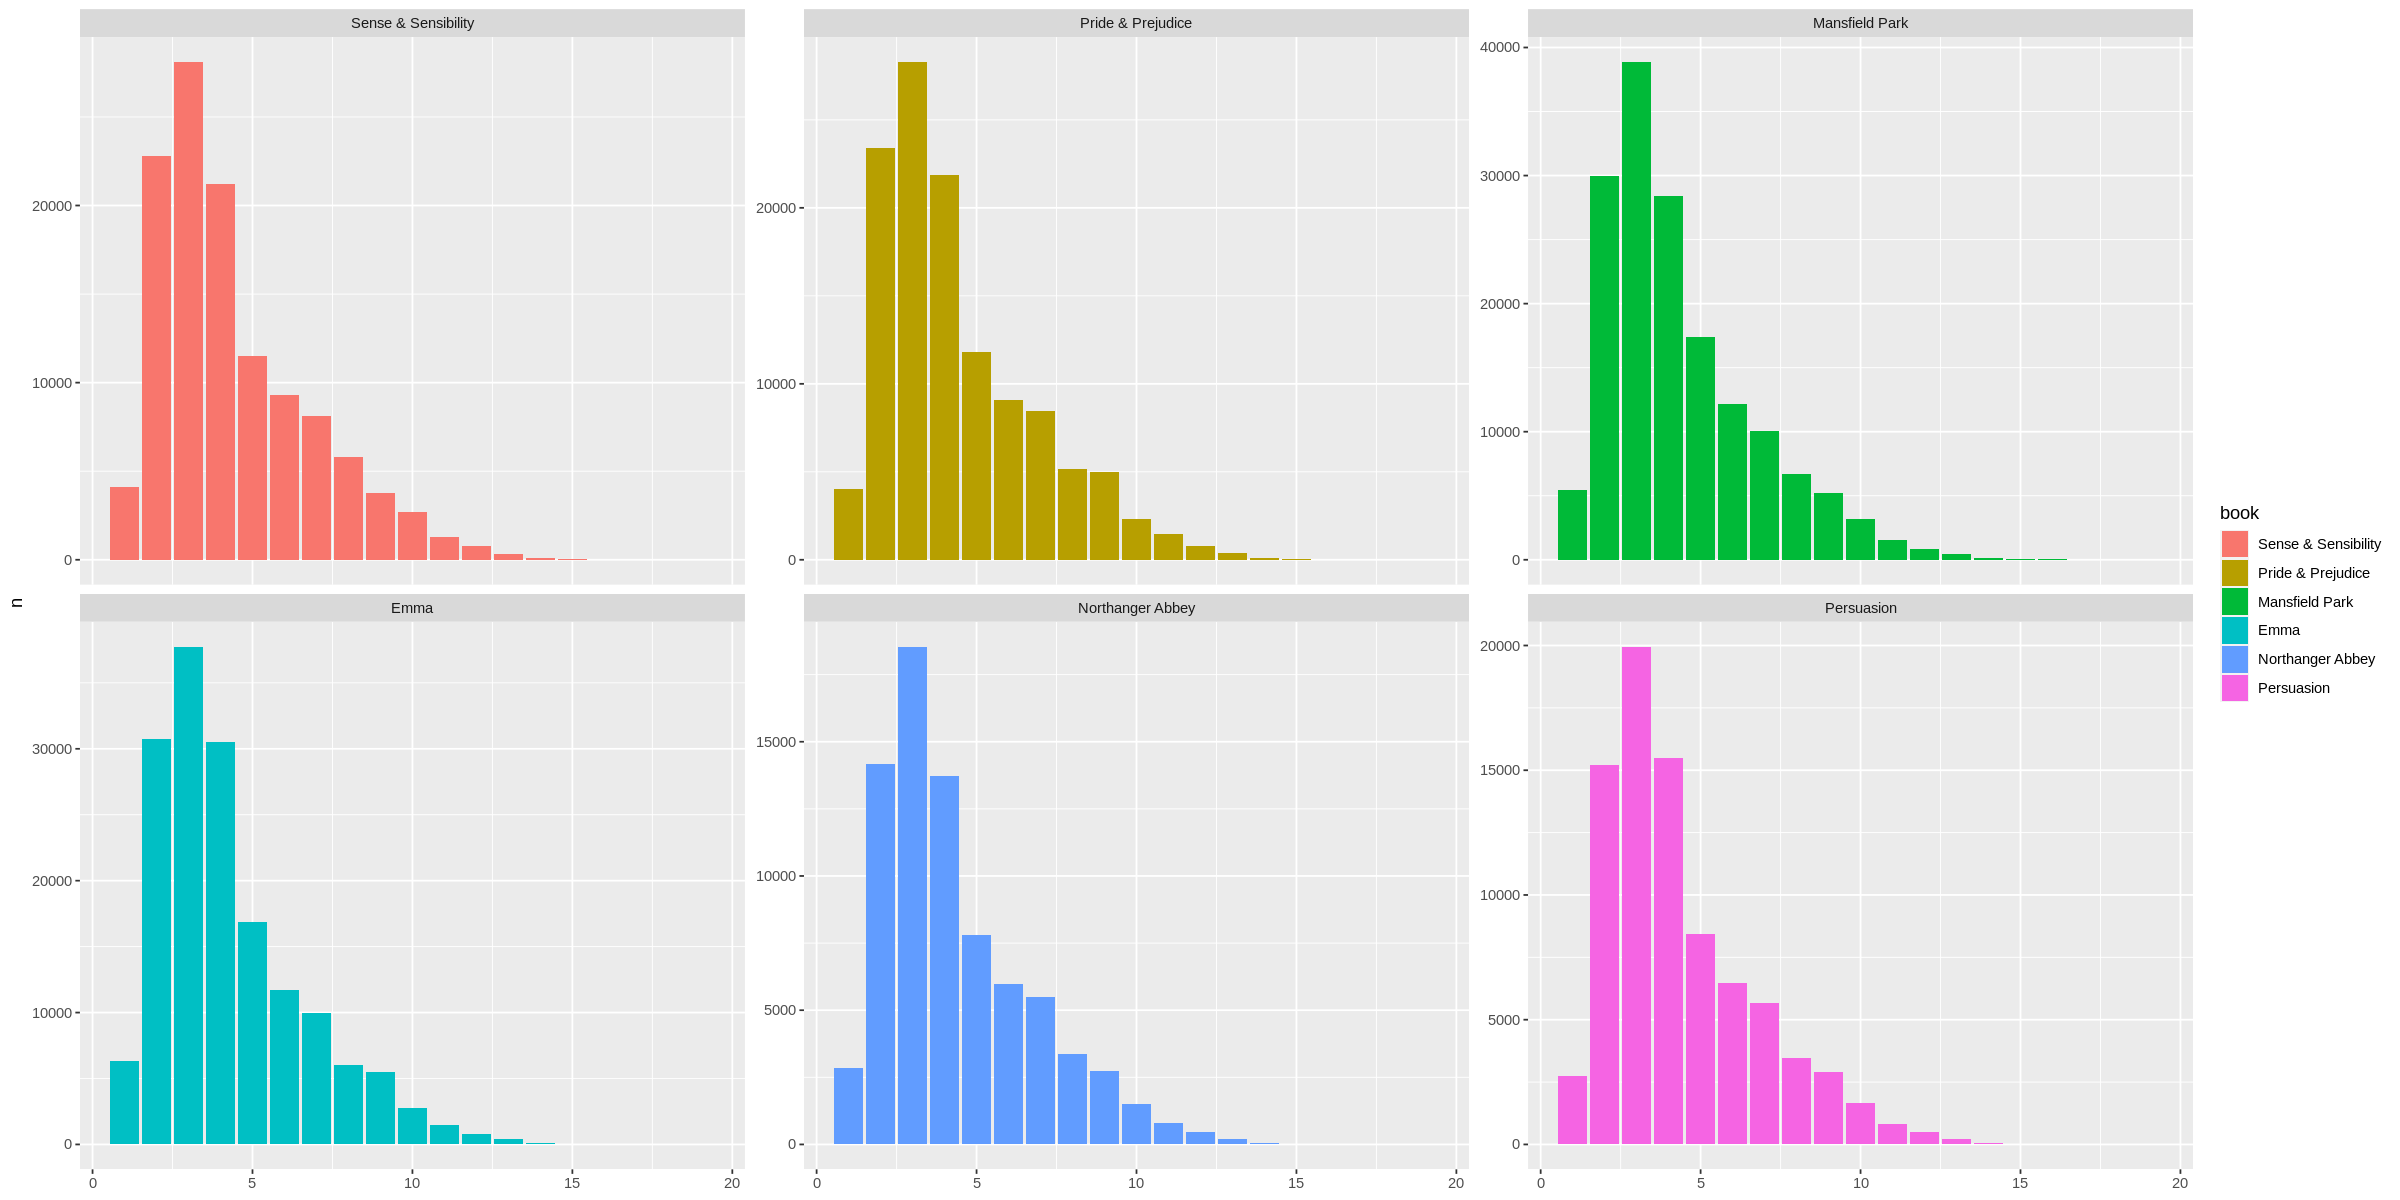

In [5]:
options(repr.plot.width = 20, repr.plot.height = 10) # a wider, shorter figure
t %>%
  ggplot(aes(lenght, n, fill = book)) +
  geom_col() +
  xlab(NULL) +
  facet_wrap(~book, ncol = 3, scales = "free_y")

Discrète, loi de poisson

**2. How about the distribution of the tf-idf weights themselves? Does that follow Zipf’s law? Please include in your response all of the following:
(1) a code snippet to obtain and visualize that distribution
(2) the resulting image
(3) your interpretation of what the distribution is likes**

In [6]:
book_words <- austen_books() %>%
  unnest_tokens(word, text) %>%
  count(book, word, sort = TRUE) %>%
  ungroup()

total_words <- book_words %>%
  group_by(book) %>%
  summarize(total = sum(n))

book_words <- left_join(book_words, total_words)

head(book_words)

Joining, by = "book"


book,word,n,total
<fct>,<chr>,<int>,<int>
Mansfield Park,the,6206,160460
Mansfield Park,to,5475,160460
Mansfield Park,and,5438,160460
Emma,to,5239,160996
Emma,the,5201,160996
Emma,and,4896,160996


In [7]:
book_words <- book_words %>%
  bind_tf_idf(word, book, n)
head(book_words)

book,word,n,total,tf,idf,tf_idf
<fct>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
Mansfield Park,the,6206,160460,0.03867631,0,0
Mansfield Park,to,5475,160460,0.03412065,0,0
Mansfield Park,and,5438,160460,0.03389007,0,0
Emma,to,5239,160996,0.03254118,0,0
Emma,the,5201,160996,0.03230515,0,0
Emma,and,4896,160996,0.03041069,0,0


In [8]:
#book_words %>% select(-total) %>% arrange(desc(tf_idf))

Selecting by tf_idf


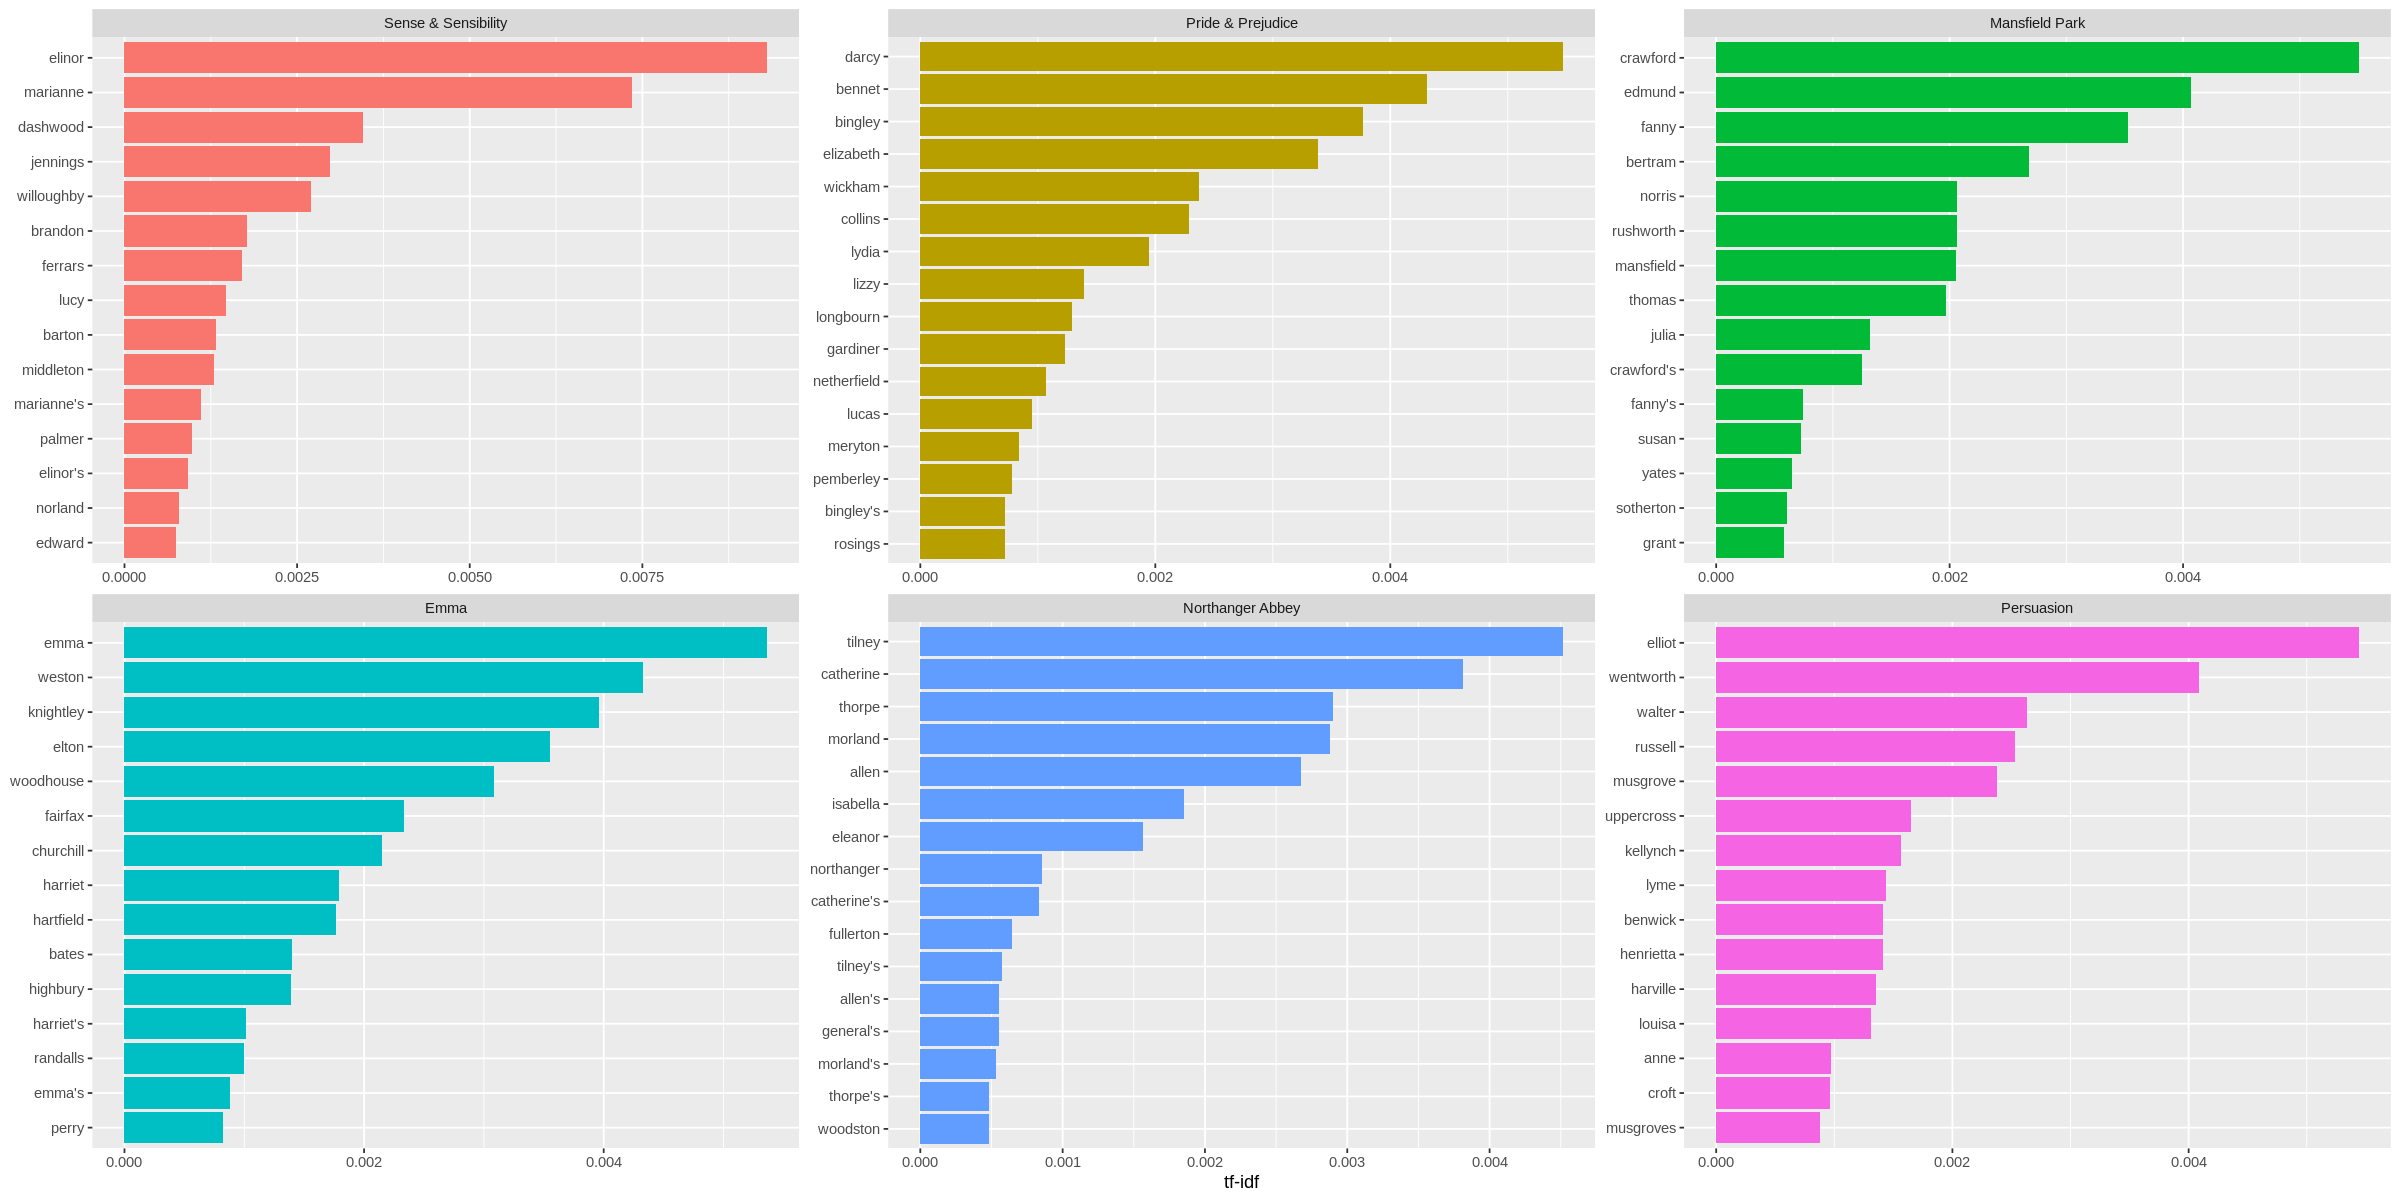

In [22]:
options(repr.plot.width = 20, repr.plot.height = 10) # a wider, shorter figure
book_words %>%
  arrange(desc(tf_idf)) %>%
  mutate(word = factor(word, levels = rev(unique(word)))) %>%
  group_by(book) %>%
  top_n(15) %>%
  ungroup %>%
  ggplot(aes(word, tf_idf, fill = book)) +
  geom_col(show.legend = FALSE) +
  labs(x = NULL, y = "tf-idf") +
  facet_wrap(~book, ncol = 3, scales = "free") +
  coord_flip() 

Chapitre 3 (The bind_tf_idf Function) – Text Mining with R

Cela semble suivre de près la loi de Zipf’s, soit la distribution de la fréquence d’un mot dans un texte est inversement proportionnelle à son rang. Tf-idf (term-frequency – inverse document frequency) va identifier les mots qui sont importants pour un document auprès d’une collection de documents.  Il va décroitre la pondération pour les mots communs utilisés et augmenter le poids des mots non-communs utilisés dans la collection de document. Par conséquent, les mots les plus important semblent être des noms propres (ex : Marianne, Emma, Catherine, etc.) ce qui semble cohérent pour des romans d’auteur. 



**3. How could you compute a similarity measure for documents based on the tf-idf matrix?
Please show a code snippet and discuss your proposal.**

In [23]:
library(topicmodels)
dtm <- book_words %>% cast_dtm(book, word, n) # we start from the regular TDM

In [24]:
fr <- book_words %>% group_by(book) %>% mutate(rank = row_number(), `term frequency` = n / total) # rank the words by frequency
head(fr)

book,word,n,total,tf,idf,tf_idf,rank,term frequency
<fct>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
Mansfield Park,the,6206,160460,0.03867631,0,0,1,0.03867631
Mansfield Park,to,5475,160460,0.03412065,0,0,2,0.03412065
Mansfield Park,and,5438,160460,0.03389007,0,0,3,0.03389007
Emma,to,5239,160996,0.03254118,0,0,1,0.03254118
Emma,the,5201,160996,0.03230515,0,0,2,0.03230515
Emma,and,4896,160996,0.03041069,0,0,3,0.03041069


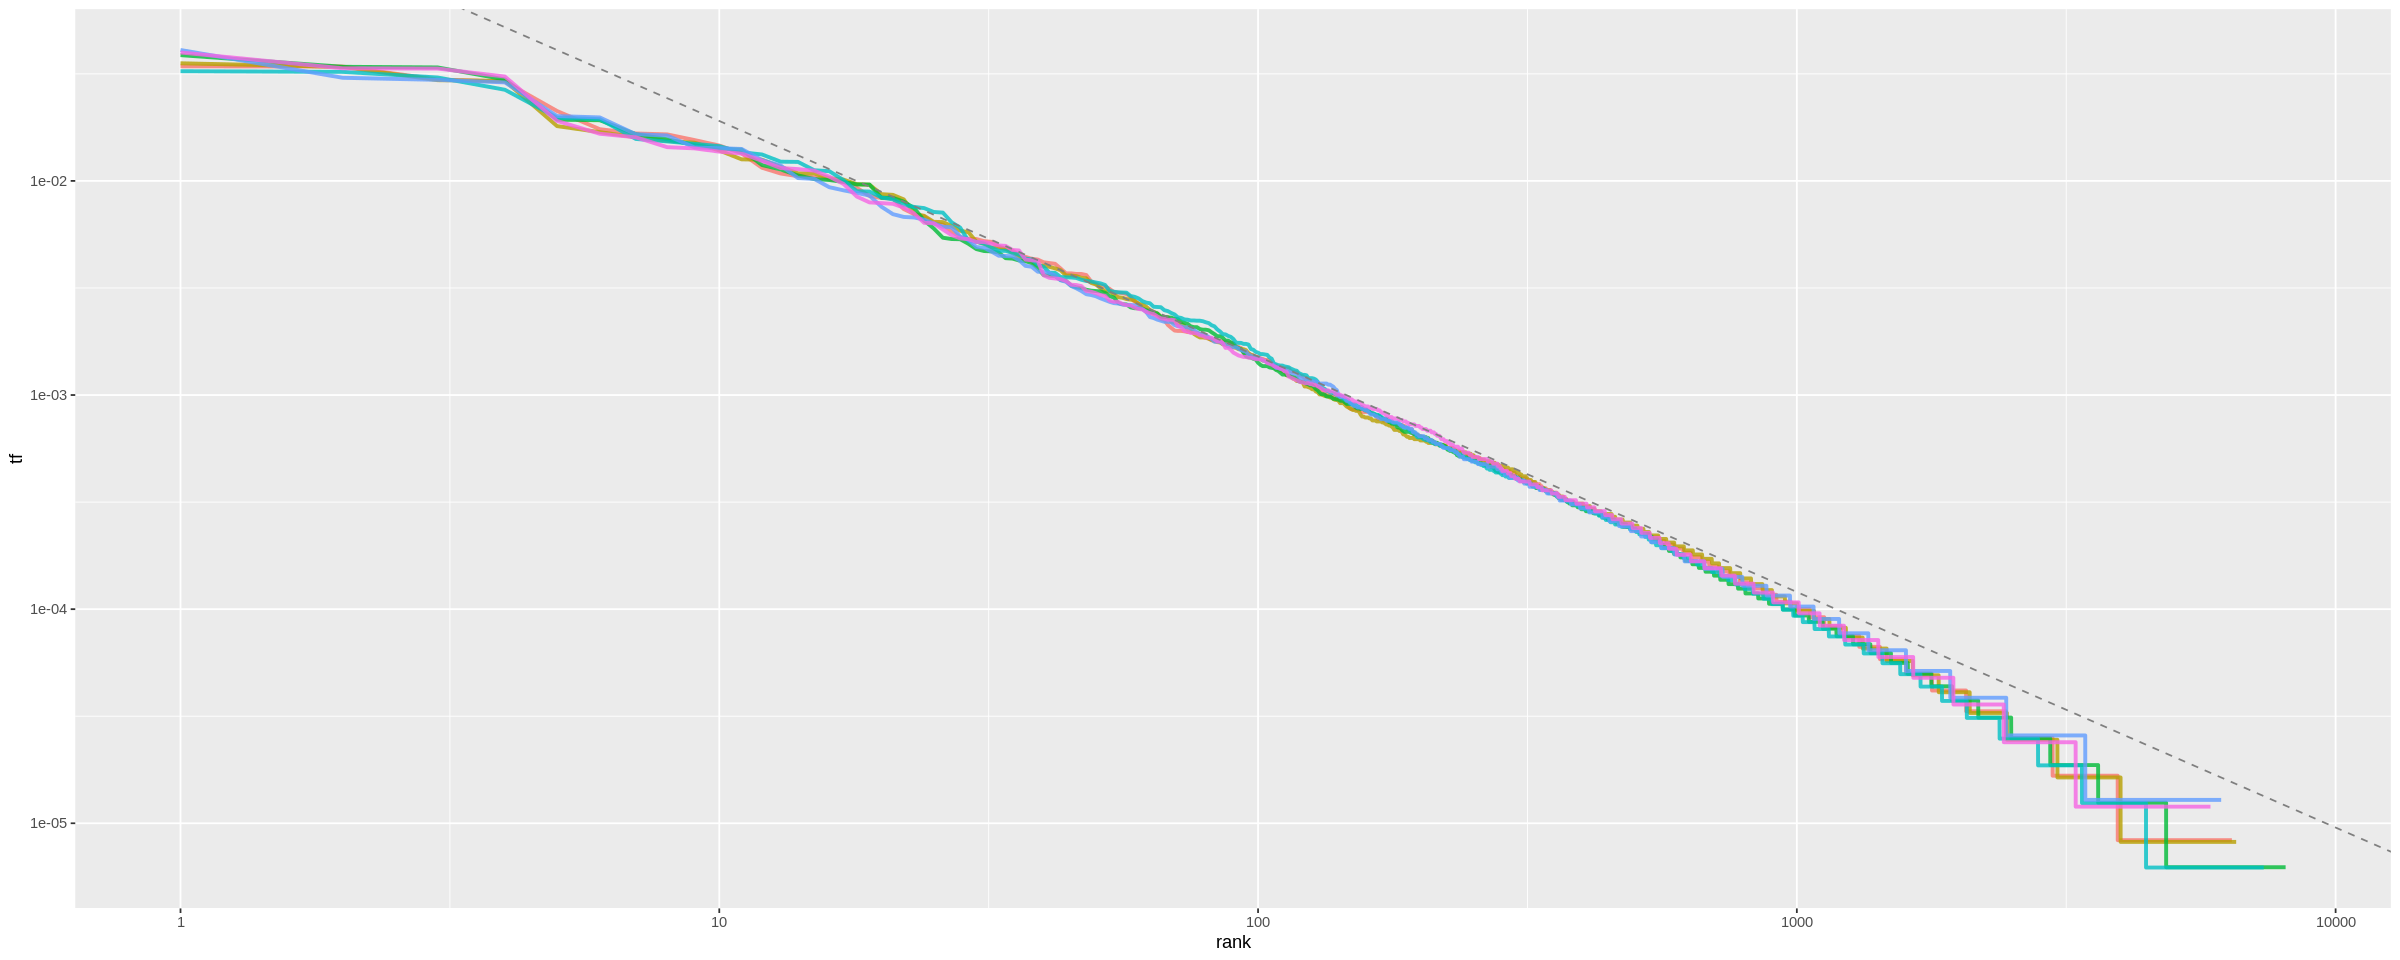

In [25]:
options(repr.plot.width = 20, repr.plot.height = 8) # a wider, shorter figure
fr %>% ggplot(aes(rank, `tf`, color = book)) + 
  geom_line(size = 1.1, alpha = 0.8, show.legend = FALSE) + 
  geom_abline(intercept = -0.62, slope = -1.1, color = "gray50", linetype = 2) + 
  scale_x_log10() + scale_y_log10()

Chapitre 3 (Zipf’s Law) – Text Mining with R

J’ai calculé le rang de chaque livre selon les mots et leur fréquence.  J’ai produit ensuite un graphique du rang selon la fréquence des mots pour chaque livre en utilisant une échelle logarithmique afin d’obtenir une ligne quasi droite. Les premiers et derniers rangs de mots possèdent une déviation avec la ligne droite. Pour les 6 livres, nous pouvons observer que les premiers rangs constituent des mots similaires entre la collection de roman (stopwords) et que l'auteur les utilise avec un faible pourcentage comparativement à d’autres langages. Cette déviation est plutôt inhabituelle. Les derniers rangs constituent des mots qui sont spécifiques pour chaque roman dans la collection et la déviation est fréquente dans ce cas (contient moins de mots rares que prévue par la loi de puissance).



**4. How could you compute a similarity measure for terms based on the tf-idf matrix? Please show again a code snippet and discuss your proposal.**

In [26]:
install.packages("tm") # this is another text mining package on which tidytext builds; install it if you do not have it yet
# consult the documentation at https://cran.r-project.org/web/packages/tm/vignettes/tm.pdf

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [27]:
# let's first filter out the lower end of the tf-idf scores
threshold <- 0.0005
top <- book_words %>% filter (tf_idf > threshold) 
matrix <- top %>% cast_dtm(book, word, tf_idf)
matrix # see the stats

<<DocumentTermMatrix (documents: 6, terms: 120)>>
Non-/sparse entries: 122/598
Sparsity           : 83%
Maximal term length: 13
Weighting          : term frequency (tf)

In [28]:
df <- tidy(matrix)
head(df)

document,term,count
<chr>,<chr>,<dbl>
Mansfield Park,fanny,0.0035249165
Emma,emma,0.0053635448
Sense & Sensibility,elinor,0.0093055524
Pride & Prejudice,elizabeth,0.0033862138
Persuasion,elizabeth,0.0006794098
Mansfield Park,crawford,0.0055050319


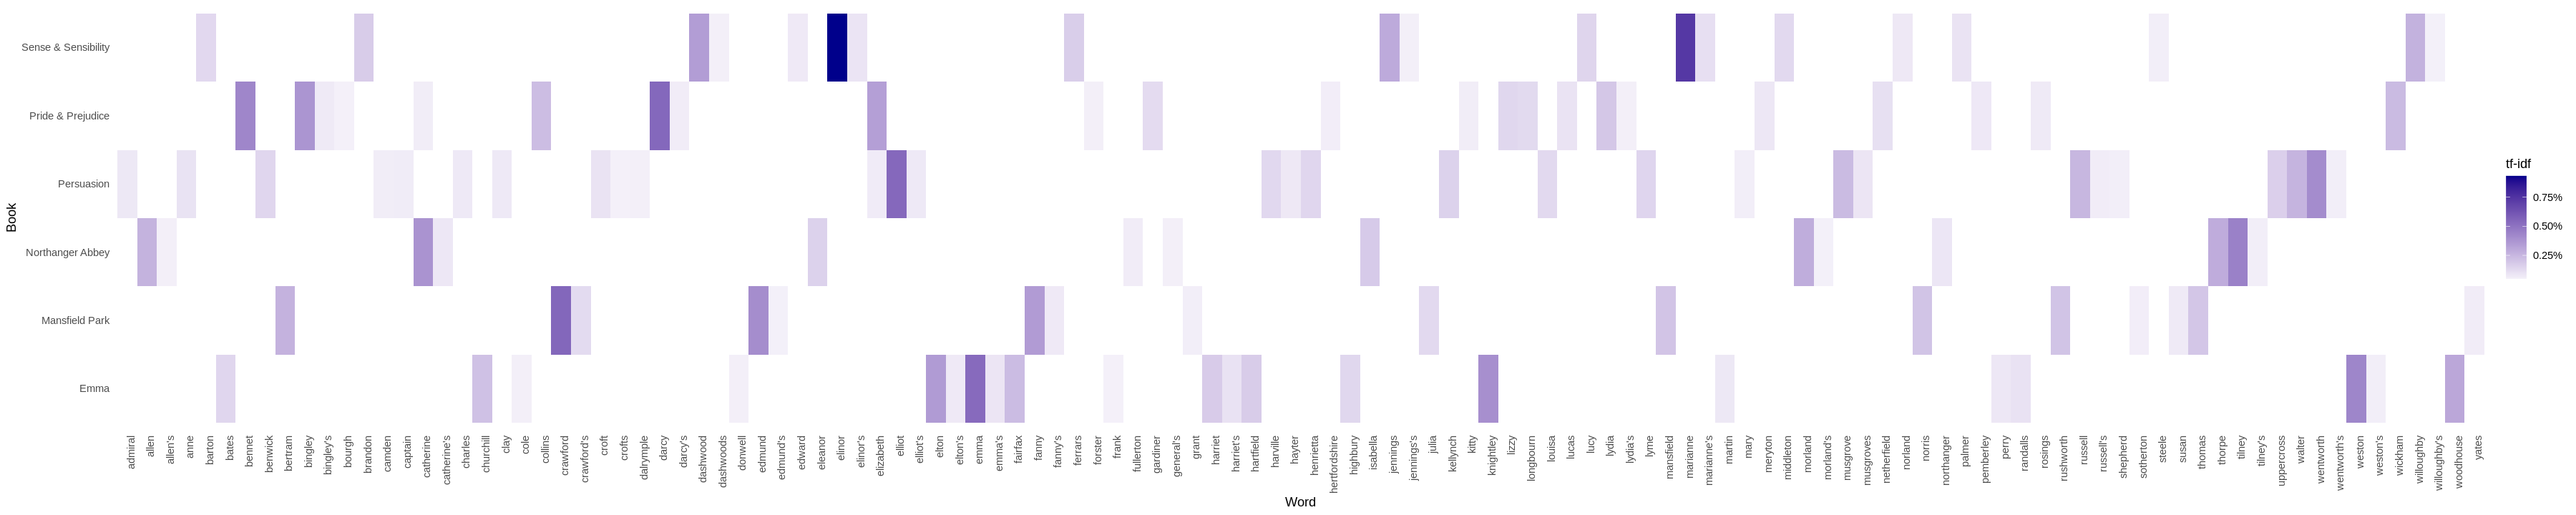

In [29]:
library(scales)
options(repr.plot.width = 30, repr.plot.height = 6) # a square is good now
df %>%
  ggplot(aes(term, document, fill = count)) + geom_tile() + scale_fill_gradient2(high = "darkblue", label = percent_format()) +
  theme_minimal() + theme(axis.text.x = element_text(angle = 90, hjust = 1), panel.grid = element_blank()) +
  labs(x = "Word", y = "Book", fill = "tf-idf")

J’ai procédé comme dans le code du cours. Importation du package tm (text mining) pour appliquer un cast_dtm par livre et mot pour obtenir le tf-idf. J’ai appliqué le même critère (0.0005) afin de faire ressortir les mots les plus spécifiques. La visualisation représente le tf-idf par roman et mots. Plus la couleur est opaque, plus le mot est significatif dans le roman auprès de la collection (td-idf). 

**5. Please investigate state-of-the-art alternatives for LDA and provide here the DOI (if applicable, URL if there is no related DOI) and a very brief critique of at least one alternative that you consider promising.**

Latent Semantic Analysis (LSA)

http://www.scholarpedia.org/article/Latent_semantic_analysis

https://towardsdatascience.com/2-latent-methods-for-dimension-reduction-and-topic-modeling-20ff6d7d547



•	Une collection de texte est séparée par document par exemple. Les lignes peuvent représenter les mots, les colonnes les document et populer selon la fréquence du mot selon le document.

•	Parfois la matrice est transformée par le tf-idf.

•	Retrait des stopwords et des suffixe des mots (ex : flying for fly)

•	SVD -  les k plus grandes valeurs singulières sont conservé et le reste est défini sur 0.  Il trouve ainsi les informations les plus importantes et utilise une dimension inférieure t pour représenter la même chose.

Il est cependant difficile de déterminer le nombre optimal de dimension. En général, les dimensions faibles consomment moins de ressources, mais ne peuvent pas distinguer les mots de sens opposé, tandis que les dimensions élevées les surmontent mais consomment plus de ressources.


**6. Please carry out LDA or another topic-detection method of your choice on your data. Include in your response the code snippet and a listing of how many tokens were associated to each topic.**

In [30]:
system2("sudo", "apt-get install libgsl0-dev") # on your own linux machine, you would use sudo apt-get install libgsl0-dev (please consider installing a Linux VM unless you already have access to a Linux machine)
install.packages("topicmodels")
install.packages("reshape")
install.packages("reshape2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [31]:
library(topicmodels)
dtm <- top %>% cast_dtm(book, word, n) # we start from the regular TDM
k <- 6 # how many topics are we expecting to detect (this could be tuned much like for k-means)
model <- LDA(dtm, k) 
topics <- tidy(model, matrix = "beta")
tail(topics)

topic,term,beta
<int>,<chr>,<dbl>
1,morland's,8.093103e-53
2,morland's,1.440538e-51
3,morland's,1.279330e-49
4,morland's,4.116699e-03
5,morland's,3.986151e-50
6,morland's,9.585305e-53


In [32]:
cw1 = subset(topics, select = -c(beta) ) #drop the beta column

In [33]:
cw2 <- cw1 %>%
    group_by(topic) %>% 
    count()
head(cw2)

topic,n
<int>,<int>
1,120
2,120
3,120
4,120
5,120
6,120


In [34]:
nrow(topics) / 6

[1] 120

J’ai utilisé le même code que dans le cours (word-topic probabilities) avec le package topicsmodels. J’ai choisi k = 6 topics (6 romans). Pour chaque roman (topic), j’ai 120 mots d’associés (token).

In [35]:
install.packages("wordcloud")
install.packages("RColorBrewer")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Loading required package: RColorBrewer



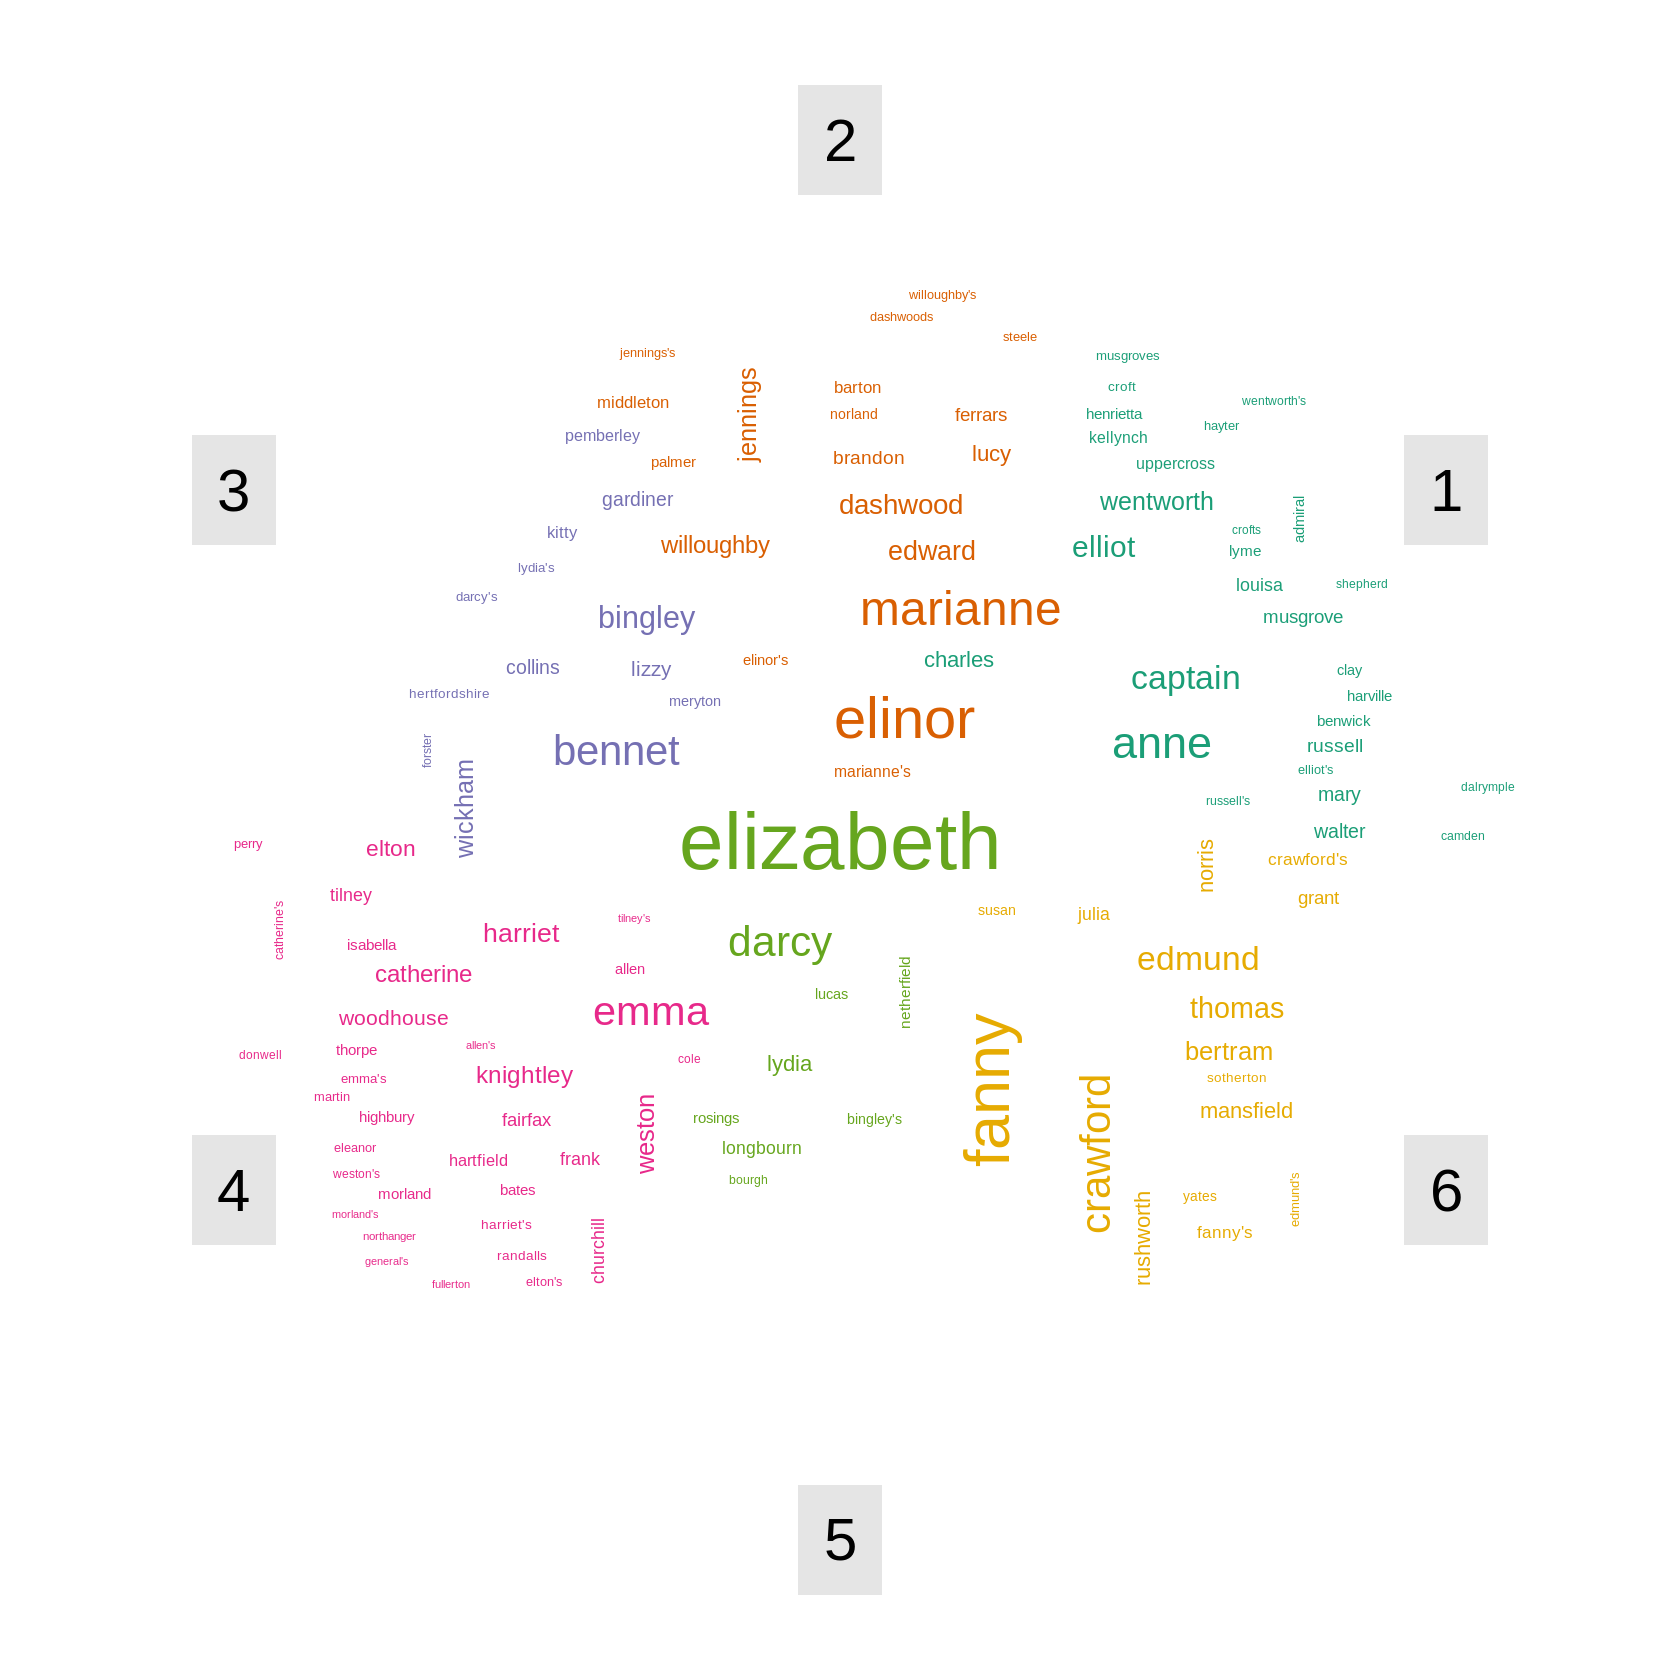

In [36]:
library(wordcloud) # check https://rpubs.com/brandonkopp/creating-word-clouds-in-r for more info
options(repr.plot.width = 14, repr.plot.height = 14) # a square is good now
par(mfrow = c(1,1))
tm <- topics %>% cast_dtm(topic, term, beta) # let us now treat the topic as the "document"
m <- t(as.matrix(tm))
colnames(m) <- 1:k
comparison.cloud(m, random.order = FALSE)

**7. Propose (either based on creativity alone or looking up alternatives) and implement an alternative way to visualize the topics (other than the comparison cloud created in the example code).**
**If you base your creation on some consulted sources, please clearly cite these sources in your response. Also, as before, include a code snippet and an image of the resulting visualization.**

https://r-charts.com/part-whole/treemapify/

In [37]:
install.packages("treemapify")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shades’, ‘ggfittext’




In [38]:
# install.packages("treemapify")
library(treemapify)
# install.packages("ggplot2")
library(ggplot2)

In [39]:
topics$topic <- as.character(topics$topic)

In [40]:
head(topics)

topic,term,beta
<chr>,<chr>,<dbl>
1,fanny,2.554813e-53
2,fanny,4.558107e-53
3,fanny,5.578388e-49
4,fanny,2.122830e-53
5,fanny,4.222667e-47
6,fanny,2.363847e-01


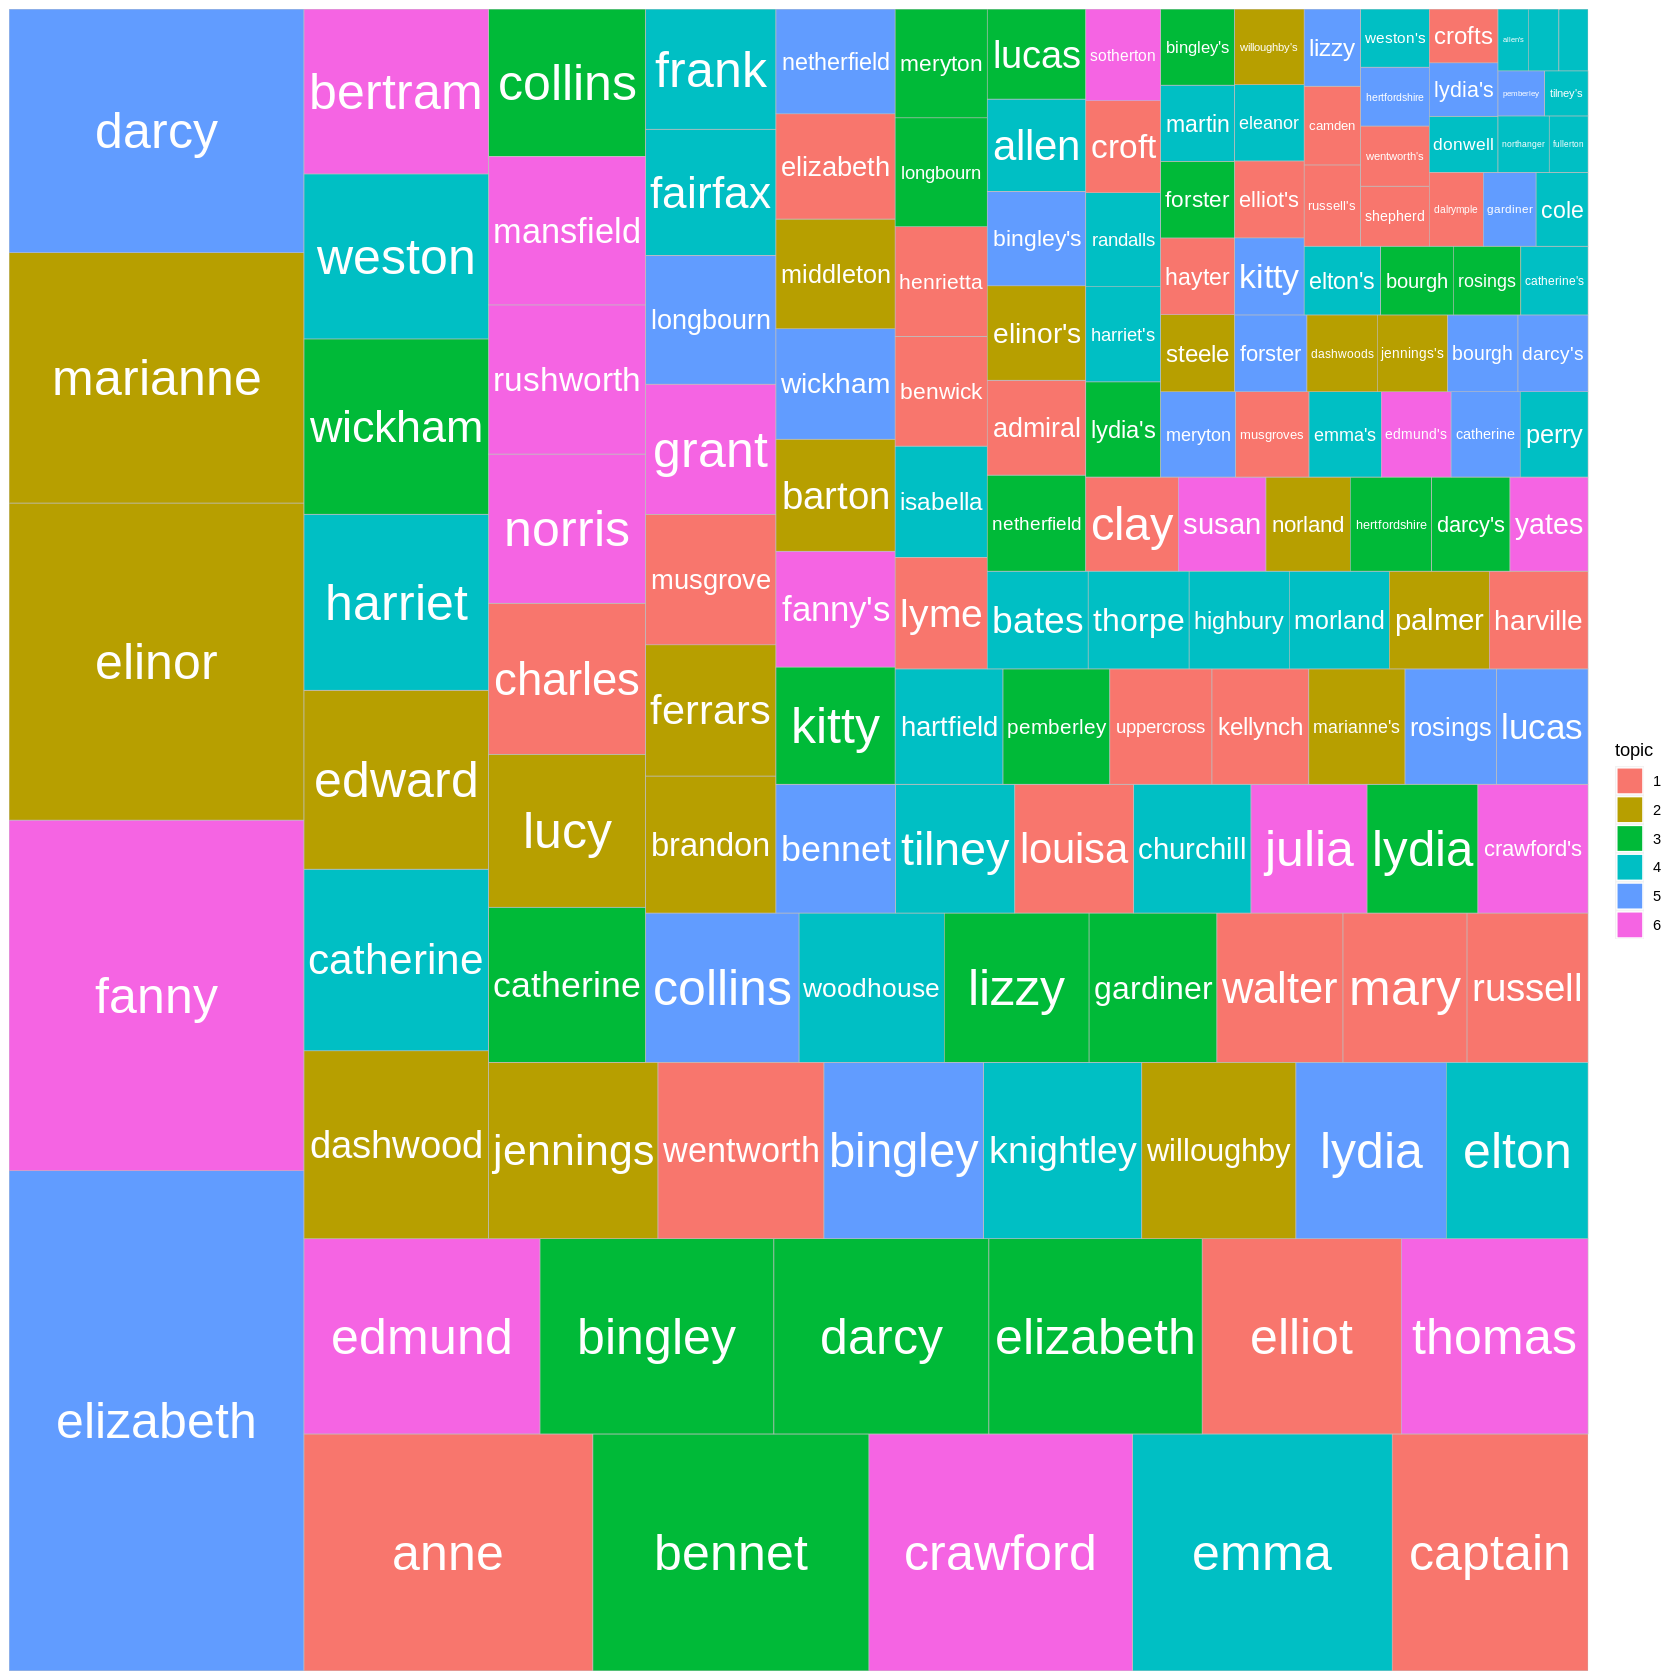

In [41]:
ggplot(topics, aes(area = beta, fill = topic, label = term)) +
  geom_treemap() +
  geom_treemap_text(colour = "white",
                    place = "centre",
                    size = 30)  

https://r-charts.com/part-whole/treemapify/

J’ai utilisé le package treemapify. Les différentes couleurs représentent les 6 sujets (roman) que nous voulons détecter (k=6).  Le format des carrées représente la probabilité du mot soit  généré par  le roman (couleur). Je remarque qu’un nettoyage pourrait être meilleur puisque le mot marianne se retrouve également avec la contraction marieanne’s. 

**8. How would you go about using tf-idf to build a list of stop words from scratch when none is available? Are there any language-specific concerns in the approach you are envisioning?**
**Your response may either be fully conceptual (pseudo-code is encouraged) or include a code snippet in R or Python. Again, please clearly cite sources if you consulted any.**

In [42]:
threshold <- 0.000000000005
top <- book_words %>% filter (tf_idf < threshold) 
matrix2 <- top %>% cast_dtm(book, word, tf_idf)
matrix2 # see the stats

<<DocumentTermMatrix (documents: 6, terms: 2584)>>
Non-/sparse entries: 15504/0
Sparsity           : 0%
Maximal term length: 16
Weighting          : term frequency (tf)

In [43]:
df <- tidy(matrix2)
tail(df,24)

document,term,count
<chr>,<chr>,<dbl>
Sense & Sensibility,austen,0
Pride & Prejudice,austen,0
Mansfield Park,austen,0
Emma,austen,0
Northanger Abbey,austen,0
Persuasion,austen,0
Sense & Sensibility,conversations,0
Pride & Prejudice,conversations,0
Mansfield Park,conversations,0


https://medium.com/analytics-vidhya/build-a-customized-stopwords-list-using-python-nlp-6fc78d4eae3c

Dans un domaine spécifique, la distribution des mots d’un texte est généralement différente de la distribution de la collection de document. Nous venons de le voir avec l’exercice de Jane Austen (les noms propres utilisés). Un autre exemple serait pour un site web de eCommerce (contactez-nous, disponible en magasin, examiner le produit, etc.). Ses mots risques d’être présent dans toutes les pages du document sans ne donner d’information importantes sur la classe du document. Il est donc préférable de supprimer ses mots.

Nous avons besoin de trier les résultats des mots du moins importants (td-idf bas) au plus informatif (td-idf élevé). Il est important de regarder les N premier mots et de les vérifier manuellement en fonction du besoin et de l’expérience dans le domaine. À titre d’exemple, si je regarde la matrice produite pour la question 4 en filtrant cette fois les résultats pour sortir les mots avec un td-idf bas, nous remarquons que les mots austen, conversations, preceded, restoring sont présents dans les 6 romans et constituent des mots vides. En moyenne, 40-60% sont des mots vides selon ma référence citée. 


**9. Based on both your own experience thus far and on what you have encountered until know or can scrape up online just to answer this question, what do you perceive to be the strengths and weaknesses of Python and R as NLP tools in particular?
Are you aware of any other tools that would be competitive for NLP tasks at present?**

Ma première expérience en R avec ce devoir. Dans mes études en actuariat nous utilisions S-Plus qui est un peu similaire je pense. Mais cela remontre à très longtemps mon utilisation. Il m’est par conséquent difficile présentement de formuler une réponse personnelle. Selon mes recherches :
https://www.sisense.com/blog/r-vs-python-whats-the-best-language-for-natural-language-processing/#vs

R :
-	Outil pour statisticien/mathématicien.
-	Populaire pour ses visualisations.
-	10 000 libraires pour le NLP.
-	Plus rapide que Python pour loader du data, faire des graphique (ex : wordcloud)

Python :
-	Langage versatile.
-	Facile à apprendre et à comprendre.
-	200 librairies pour le NLP.

Autres outils :
-	GCP: https://cloud.google.com/natural-language/docs/how-to?hl=fr
-	Spark: https://www.databricks.com/blog/2017/10/19/introducing-natural-language-processing-library-apache-spark.html
